In [2]:
# Importing Packages

%matplotlib inline
import sys
import json
import random
import pickle
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import MWETokenizer

# 1. Average Rent in Ireland

In [3]:
# Not a large dataset so no point in using json

average_rent = pd.read_csv(r"C:\Users\green\Downloads\STND RNT Q2 2023.csv")

In [4]:
# There is an obligatory space at the end of National and Unnamed: 0 Doesn't make sense

average_rent.rename(columns = {'National ':'National', 'Unnamed: 0':'Quarter'}, inplace = True)

<AxesSubplot:xlabel='Quarter'>

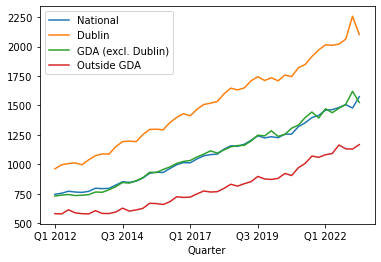

In [5]:
average_rent.plot(x='Quarter', y=['National', 'Dublin', 'GDA (excl. Dublin)', 'Outside GDA'])

In [6]:
average_rent.head()

,Quarter,National,Dublin,GDA (excl. Dublin),Outside GDA
0,Q1 2012,745,961,730,580
1,Q2 2012,754,996,738,578
2,Q3 2012,771,1006,743,613
3,Q4 2012,764,1012,734,587
4,Q1 2013,761,996,737,580


# Average Income in Ireland

In [7]:
mean_income = pd.read_csv(r"C:\Users\green\Downloads\DEA01.20240226223550.csv")

Lot's of data cleaning needs to be done on this dataset, mostly condensing. I only want the national average earnings per year, not seperated by gender or economic center.

In [8]:
# Dropping Employments in Top 1% of Earnings - Median Annual Earnings

mean_income = mean_income[mean_income['Statistic Label'] != 'Employments in Top 1% of Earnings - Median Annual Earnings']

# Dropping Employments in Top 1% of Earnings - Mean Annual Earnings

mean_income = mean_income[mean_income['Statistic Label'] != 'Employments in Top 1% of Earnings - Mean Annual Earnings']

# Dropping Employments in Top 10% of Earnings - Median Annual Earnings

mean_income = mean_income[mean_income['Statistic Label'] != 'Employments in Top 10% of Earnings - Median Annual Earnings']

# Dropping Employments in Top 10% of Earnings - Mean Annual Earnings

mean_income = mean_income[mean_income['Statistic Label'] != 'Employments in Top 10% of Earnings - Mean Annual Earnings']

# Dropping All Employments - Mean Annual Earnings

mean_income = mean_income[mean_income['Statistic Label'] != 'All Employments - Mean Annual Earnings']

# Dropping all stats that seperate Male or Female

mean_income = mean_income[mean_income['Sex'] != 'Male']
mean_income = mean_income[mean_income['Sex'] != 'Female']

In [9]:
# Making sure it is not seperated by economic sector

mean_income = mean_income[mean_income['NACE Rev 2 Economic Sector'] == 'All NACE economic sectors']

In [10]:
# Dropping unnecessary columns

mean_income = mean_income.drop(columns=['STATISTIC', 'Statistic Label', 'TLIST(A1)', 'C02199V02655', 
                                       'Sex', 'NACE Rev 2 Economic Sector', 'UNIT', 'C02665V03225'])

In [11]:
# Dropping 2011 because that year isn't in the other dataset

mean_income = mean_income[mean_income['Year'] != 2011]

Now we have to divide every number in the "value" row by 12 as the average_rent dataset's  value is monthly, while this is yearly.

In [12]:
mean_income['VALUE'] = mean_income['VALUE'] / 12

# Converting Average Income to Quarterly

In [13]:
# Initializing an empty list

duplicated_rows = []

for index, row in mean_income.iterrows():
    
    # Duplicating the row four times and assigning the quarter
    
    for quarter in ['Q1', 'Q2', 'Q3', 'Q4']:
        
        # Copy of the original row
        
        duplicated_row = row.copy()  
        
        # Assigning the corresponding quarter
        
        duplicated_row['Quarter'] = quarter
        duplicated_rows.append(duplicated_row)

# Create a new DataFrame from the duplicated rows

mean_income = pd.DataFrame(duplicated_rows)

# Resetting the index

mean_income.reset_index(drop=True, inplace=True)

In [14]:
# I am going to rename "VALUE" to "Average Income", and "Quarter" to "Q" so I can have a more similar quarter later

mean_income.rename(columns = {'VALUE':'Average Income', 'Quarter':'Q'}, inplace = True)

In [15]:
# Creating new Quarter row that will eventuall match the other dataset

mean_income.insert(3, 'Quarter', '0')

In [16]:
# New Quarter row that matches the other dataset

mean_income['Quarter'] = mean_income['Q'].astype(str) + ' ' + mean_income['Year'].astype(int).astype(str)

# Merging the Datasets

In [17]:
# df will be our final merged dataset name, it's what a bunch of websites use as the dataset name so I guess I'll use it

df = pd.merge(average_rent, mean_income, on='Quarter')

# Adding a Stat
I want to add the average increase in cost and income so we can compare the numbers. Find this by looking at the slope.

In [18]:
income_slope = (df.at[43, 'Average Income'] - df.at[0, 'Average Income'])/43
national_slope = (df.at[43, 'National'] - df.at[0, 'National'])/43
dublin_slope = (df.at[43, 'Dublin'] - df.at[0, 'Dublin'])/43

figure_stats = "National Income Increase: +" + str(national_slope)[:5] + "\nDublin Cost Increase: +" + str(dublin_slope)[:5] + "\nAverage Cost Increase: +" + str(income_slope)[:5]

# Creating the Final Graph

Text(0.95, 0.5, 'National Income Increase: +17.72\nDublin Cost Increase: +25.62\nAverage Cost Increase: +17.29')

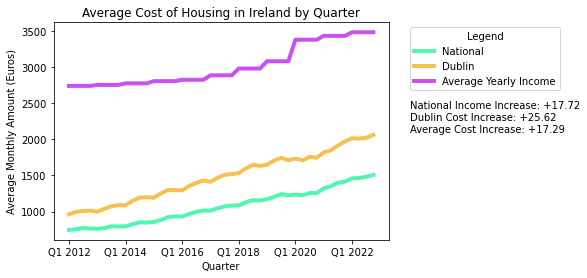

In [19]:
plt.plot(df['Quarter'], df['National'], label='National', linewidth=4, color='#52F5B2')
plt.plot(df['Quarter'], df['Dublin'], label='Dublin', linewidth=4, color='#F5C251')
plt.plot(df['Quarter'], df['Average Income'], label='Average Yearly Income', linewidth=4, color='#CB51F5')

# Every other first quarter is labeled

plt.xticks(range(0, 43, 8))

plt.xlabel('Quarter')
plt.ylabel('Average Monthly Amount (Euros)')
plt.title('Average Cost of Housing in Ireland by Quarter')

plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figtext(.95, 0.50, figure_stats)